<sub>Developed by SeongKu Kang, August 2025 — Do not distribute</sub>

# Advanced Exercise: Product Category Classification with Label GNN

This notebook builds on the previous assignment **P2c: train-with-BERT-embedding-limited-label**.  
The setup is similar, but here we take one step further by **leveraging label structure information**.

---

### Recall: Label Embedding (Inner Product) Classifier
- Each **data instance** (e.g., a product description) is projected into a hidden space.  
- Each **label** has its own embedding vector.  
- Classification is performed via an **inner product** between the projected instance and label embeddings.  

Formally:
$$
\text{logits}(x) = \text{Proj}(x) \cdot E^T
$$

where  
- $\text{Proj}(x)$ is the projected input representation,  
- $E$ is the matrix of label embeddings.  

Originally, label embeddings $E$ were initialized with **BERT mean-pooled representations** of the label names.  
One small difference from the previous P2 assignment is that we now use only leaf-level categories for the label embeddings.  

---

### What’s New Here?
- In addition to BERT initialization, we are now given **a graph of label relationships**, derived from the category hierarchy.  
  - Example: if two categories share the same parent (e.g., *“iPhone Cases”* and *“iPhone Chargers”* under *“iPhone Accessories”*), we connect them with an edge.  
  - We provide the **normalized adjacency matrix**, so your main task is to **implement the GNN part**.

- To enrich the label embeddings, we propagate information over this label graph using a **Graph Neural Network (GNN)**:
  $$
  E' = \text{GNN}(E, A_{\text{label}})
  $$
  where $E$ are the initial label embeddings and $A_{\text{label}}$ is the adjacency between labels.  

- Final classification then uses these **graph-enriched label embeddings**:
  $$
  \text{logits}(x) = \text{Proj}(x) \cdot (E')^T
  $$

In [1]:
import json
from tqdm import tqdm
from pathlib import Path
from utils import * 
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Default paths
ROOT = Path("dataset") # Root dataset directory
CORPUS_PATH = ROOT / "corpus.jsonl" # Product corpus file (JSON Lines): Each line contains a product ID and its associated text description.
EMB_PATH = ROOT / "corpus_bert_mean.pt"

# Task 1: Product category classification
LABEL_MAP_PATH = ROOT / "category_classification" 
LABEL2ID_PATH = LABEL_MAP_PATH / "label2labelid.json" 
ID2LABEL_PATH = LABEL_MAP_PATH / "labelid2label.json" 
PID2LABEL_TRAIN_LIMITED_PATH = LABEL_MAP_PATH / "pid2labelids_train_limited.json" 
PID2LABEL_TEST_PATH = LABEL_MAP_PATH / "pid2labelids_test.json" 
LABEL_EMB_PATH = LABEL_MAP_PATH / "category_labels_leaf_bert_mean.pt"

In [3]:
pid2text = load_corpus(CORPUS_PATH) # load corpus

label2id = load_json(LABEL2ID_PATH)
id2label = load_json(ID2LABEL_PATH)
pid2label_train_limited = load_json(PID2LABEL_TRAIN_LIMITED_PATH)
pid2label_test = load_json(PID2LABEL_TEST_PATH)

# loading pre-trained embeddings
corpus_data = torch.load(EMB_PATH)  # {"ids": [...], "embeddings": Tensor}
pid_list = corpus_data["ids"]
pid2idx = {pid: i for i, pid in enumerate(pid_list)}
embeddings = corpus_data["embeddings"]

label_data = torch.load(LABEL_EMB_PATH)
label_emb = label_data["embeddings"].to(device)

In [4]:
class ProductCategoryEmbeddingDataset(Dataset):
    def __init__(self, pid2label, pid2idx, embeddings):
        self.pids = list(pid2label.keys())
        self.labels = [pid2label[pid] for pid in self.pids]
        self.indices = [pid2idx[pid] for pid in self.pids]
        self.embeddings = embeddings

    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):
        emb = self.embeddings[self.indices[idx]]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"X": emb, "y": label}

In [5]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader, device="cpu"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch["X"].to(device)
            y = batch["y"].to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

In [6]:
# Build test dataset and dataloader from precomputed embeddings
test_dataset = ProductCategoryEmbeddingDataset(pid2label_test, pid2idx, embeddings)
test_loader = DataLoader(test_dataset, batch_size=64)

# Model dimensions
input_dim = embeddings.shape[1]   # Size of embedding vector (feature dimension)
num_classes = len(label2id)       # Number of category classes

# Keep track of product IDs
all_pids = set(pid_list)
test_pids = set(pid2label_test.keys())

In [7]:
# Build dataset with limited labeled products
train_dataset = ProductCategoryEmbeddingDataset(pid2label_train_limited, pid2idx, embeddings)

# Split into train/validation sets (80% / 20%)
val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_split, val_split = random_split(train_dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader = DataLoader(val_split, batch_size=64)

In [8]:
# Find products without labels
used_pids = set(pid2label_train_limited.keys())
unlabeled_pids = all_pids - used_pids

# Ratio of unlabeled products in the whole corpus
unlabeled_ratio = len(unlabeled_pids) / len(all_pids)

print(f"[Unlabeled] {len(unlabeled_pids)} / {len(all_pids)} = {unlabeled_ratio:.2%}")

[Unlabeled] 32810 / 39452 = 83.16%


In [9]:
results_dict = {'valid':{}, 'test': {}}

## [Part A]: revisit Classification with label embedding

This part is identical to the previous assignment P2c: train-with-BERT-embedding-limited-label.

In [10]:
# Classifier that uses label embeddings to make predictions
class InnerProductClassifier(nn.Module):
    def __init__(self, input_dim, label_embeddings, trainable_label_emb=True):
        super().__init__()
        # Project input features into the same dimension as label embeddings
        self.proj = nn.Linear(input_dim, label_embeddings.size(1))

        if trainable_label_emb:
            # Label embeddings are trainable parameters
            self.label_emb = nn.Parameter(label_embeddings.clone())
        else:
            # Label embeddings are fixed (not updated during training)
            self.register_buffer("label_emb", label_embeddings.clone())

    def forward(self, x):
        # Project input feature vectors
        x_proj = self.proj(x)
        # Compute logits as similarity with each label embedding
        logits = torch.matmul(x_proj, self.label_emb.T)
        return logits

In [11]:
model = InnerProductClassifier(input_dim, label_emb).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [12]:
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []
test_acc_list = []

EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        X = batch["X"].to(device)
        y = batch["y"].to(device)
        logits = model(X)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

    # === Validation ===
    val_result = evaluate(model, val_loader, device=device)
    val_acc = val_result["accuracy"]
    val_acc_list.append(val_acc)

    is_improved = val_acc > best_val_acc
    print_eval_result(val_result, stage="val", is_improved=is_improved)

    # === Test ===
    test_result = evaluate(model, test_loader, device=device)
    test_acc = test_result["accuracy"]
    test_acc_list.append(test_acc)
    print_eval_result(test_result, stage="test")

    # === Update best model ===
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # === Early stopping ===
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 134.89it/s]


[Epoch 1] Train Loss: 5.4134
[VAL ] Acc: 0.1453 | F1-macro: 0.0531 *
[TEST] Acc: 0.1615 | F1-macro: 0.0454


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 222.37it/s]


[Epoch 2] Train Loss: 4.0209
[VAL ] Acc: 0.2410 | F1-macro: 0.1134 *
[TEST] Acc: 0.2599 | F1-macro: 0.1136


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 219.26it/s]


[Epoch 3] Train Loss: 3.3261
[VAL ] Acc: 0.2824 | F1-macro: 0.1492 *
[TEST] Acc: 0.3017 | F1-macro: 0.1558


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 221.66it/s]


[Epoch 4] Train Loss: 2.8521
[VAL ] Acc: 0.3464 | F1-macro: 0.2131 *
[TEST] Acc: 0.3647 | F1-macro: 0.2211


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 222.85it/s]


[Epoch 5] Train Loss: 2.4647
[VAL ] Acc: 0.3652 | F1-macro: 0.2371 *
[TEST] Acc: 0.3898 | F1-macro: 0.2526


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 223.38it/s]


[Epoch 6] Train Loss: 2.1289
[VAL ] Acc: 0.4134 | F1-macro: 0.2760 *
[TEST] Acc: 0.4216 | F1-macro: 0.2849


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 223.26it/s]


[Epoch 7] Train Loss: 1.8722
[VAL ] Acc: 0.4315 | F1-macro: 0.2971 *
[TEST] Acc: 0.4329 | F1-macro: 0.3055


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 225.16it/s]


[Epoch 8] Train Loss: 1.6520
[VAL ] Acc: 0.4593 | F1-macro: 0.3287 *
[TEST] Acc: 0.4654 | F1-macro: 0.3484


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 225.79it/s]


[Epoch 9] Train Loss: 1.4395
[VAL ] Acc: 0.4511 | F1-macro: 0.3226
[TEST] Acc: 0.4539 | F1-macro: 0.3373


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 224.56it/s]


[Epoch 10] Train Loss: 1.2768
[VAL ] Acc: 0.4789 | F1-macro: 0.3547 *
[TEST] Acc: 0.5009 | F1-macro: 0.3963


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 221.51it/s]


[Epoch 11] Train Loss: 1.1286
[VAL ] Acc: 0.5173 | F1-macro: 0.3818 *
[TEST] Acc: 0.5151 | F1-macro: 0.4082


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 226.35it/s]


[Epoch 12] Train Loss: 1.0230
[VAL ] Acc: 0.5241 | F1-macro: 0.3890 *
[TEST] Acc: 0.5237 | F1-macro: 0.4190


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 222.44it/s]


[Epoch 13] Train Loss: 0.9253
[VAL ] Acc: 0.5361 | F1-macro: 0.4090 *
[TEST] Acc: 0.5264 | F1-macro: 0.4332


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 225.05it/s]


[Epoch 14] Train Loss: 0.8171
[VAL ] Acc: 0.5392 | F1-macro: 0.4132 *
[TEST] Acc: 0.5479 | F1-macro: 0.4632


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 220.76it/s]


[Epoch 15] Train Loss: 0.7405
[VAL ] Acc: 0.5384 | F1-macro: 0.4093
[TEST] Acc: 0.5483 | F1-macro: 0.4654


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 220.33it/s]


[Epoch 16] Train Loss: 0.6646
[VAL ] Acc: 0.5512 | F1-macro: 0.4244 *
[TEST] Acc: 0.5528 | F1-macro: 0.4680


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 224.64it/s]


[Epoch 17] Train Loss: 0.5898
[VAL ] Acc: 0.5685 | F1-macro: 0.4337 *
[TEST] Acc: 0.5569 | F1-macro: 0.4681


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 224.89it/s]


[Epoch 18] Train Loss: 0.5383
[VAL ] Acc: 0.5542 | F1-macro: 0.4316
[TEST] Acc: 0.5556 | F1-macro: 0.4723


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 224.84it/s]


[Epoch 19] Train Loss: 0.5033
[VAL ] Acc: 0.5587 | F1-macro: 0.4313
[TEST] Acc: 0.5675 | F1-macro: 0.4810


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 222.32it/s]


[Epoch 20] Train Loss: 0.4549
[VAL ] Acc: 0.5648 | F1-macro: 0.4370
[TEST] Acc: 0.5745 | F1-macro: 0.4945


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 223.61it/s]


[Epoch 21] Train Loss: 0.4110
[VAL ] Acc: 0.5745 | F1-macro: 0.4520 *
[TEST] Acc: 0.5664 | F1-macro: 0.4871


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 225.94it/s]


[Epoch 22] Train Loss: 0.3766
[VAL ] Acc: 0.5708 | F1-macro: 0.4488
[TEST] Acc: 0.5709 | F1-macro: 0.4950


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 225.84it/s]


[Epoch 23] Train Loss: 0.3444
[VAL ] Acc: 0.5806 | F1-macro: 0.4501 *
[TEST] Acc: 0.5732 | F1-macro: 0.4937


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 224.79it/s]


[Epoch 24] Train Loss: 0.3103
[VAL ] Acc: 0.5648 | F1-macro: 0.4395
[TEST] Acc: 0.5786 | F1-macro: 0.5035


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 219.67it/s]


[Epoch 25] Train Loss: 0.2897
[VAL ] Acc: 0.5693 | F1-macro: 0.4488
[TEST] Acc: 0.5808 | F1-macro: 0.5117


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 225.98it/s]


[Epoch 26] Train Loss: 0.2635
[VAL ] Acc: 0.5655 | F1-macro: 0.4482
[TEST] Acc: 0.5761 | F1-macro: 0.5018


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 225.16it/s]


[Epoch 27] Train Loss: 0.2448
[VAL ] Acc: 0.5791 | F1-macro: 0.4616
[TEST] Acc: 0.5797 | F1-macro: 0.5047


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 225.88it/s]


[Epoch 28] Train Loss: 0.2276
[VAL ] Acc: 0.5700 | F1-macro: 0.4488
[TEST] Acc: 0.5808 | F1-macro: 0.5057
[Early Stopping] No improvement for 5 consecutive epochs.


In [13]:
model.load_state_dict(best_model_state)
final_test_result = evaluate(model, test_loader, device=device)
print_eval_result(final_test_result, stage="final_test")

results_dict['valid']['label_train'] = val_acc_list[:]
results_dict['test']['label_train'] = test_acc_list[:]

[FINAL_TEST] Acc: 0.5732 | F1-macro: 0.4937


## [Part B]: Classification with Label GNN

In [22]:
# a normalized version of adjacency matrix is given here. you don't need to dig in this generation process
A_hat = build_leaf_adj(id2label, label2id)

In [23]:
class LabelGCN(nn.Module):
    """
    Multi-layer Graph Convolutional Network (GCN) encoder for label embeddings.
    Each layer applies:
        H <- torch.matmul(A_hat, H)
        H <- torch.matmul(H, W)
    followed by ReLU + Dropout (except the last layer).
    """
    def __init__(self, emb_dim, num_layers=2, dropout=0.5):
        super().__init__()

        # Learnable weight matrices for each GCN layer (square: emb_dim x emb_dim)
        self.weights = nn.ParameterList([nn.Parameter(torch.empty(emb_dim, emb_dim)) for _ in range(num_layers)])
        for W in self.weights:
            nn.init.xavier_uniform_(W)  # Xavier init for stability

        self.num_layers = num_layers
        self.dropout = dropout

    def forward(self, H, A_hat):
        """
        Args:
            H: Initial label embeddings (num_labels x emb_dim)
            A_hat: Normalized adjacency matrix (num_labels x num_labels)

        Returns:
            Updated label embeddings (num_labels x emb_dim)
        """
        for i, W in enumerate(self.weights):
            # Message passing: aggregate neighbor embeddings
            H = torch.matmul(A_hat, H)     # (num_labels x num_labels) * (num_labels x emb_dim)

            # Linear transformation with learnable weights
            H = torch.matmul(H, W)         # (num_labels x emb_dim) * (emb_dim x emb_dim)

            # Apply non-linearity + dropout (except last layer)
            if i < self.num_layers - 1:
                H = F.relu(H)
                H = F.dropout(H, p=self.dropout, training=self.training)
        return H

class GCNEnhancedClassifier(nn.Module):
    """
    Classifier that combines:
      - Document representation (x) projected into label embedding space
      - Label embeddings refined by a GCN over the label hierarchy
    """
    def __init__(self, input_dim, label_init_emb, A_hat, num_layers=1, dropout=0.5):
        super().__init__()
        emb_dim = label_init_emb.size(1)  # dimension of label embeddings

        # Project document embeddings to the same space as labels
        self.proj = nn.Linear(input_dim, emb_dim)

        # GCN to propagate information between related labels
        self.gcn = LabelGCN(emb_dim=emb_dim, num_layers=num_layers, dropout=dropout)

        # Trainable initial label embeddings
        self.label_init_emb = nn.Parameter(label_init_emb.clone())

        # Store adjacency matrix (not trainable, fixed as buffer)
        self.register_buffer("A_hat", A_hat)
        self.dropout = dropout

    def forward(self, x):
        """
        Args:
            x: Input embeddings for documents (batch_size x input_dim)

        Returns:
            logits: Prediction scores (batch_size x num_labels)
        """
        # Update label embeddings with GCN
        label_emb = self.gcn(self.label_init_emb, self.A_hat)   # (num_labels x emb_dim)

        # Project input to label space
        x_proj = self.proj(x)                                  # (batch_size x emb_dim)
        x_proj = F.dropout(x_proj, p=self.dropout, training=self.training)

        # Compute similarity between inputs and labels
        logits = torch.matmul(x_proj, label_emb.T)             # (batch_size x num_labels)

        return logits

In [24]:
model = GCNEnhancedClassifier(embeddings.size(1), label_emb, A_hat.to(device), num_layers=1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [25]:
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []
test_acc_list = []

EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        X = batch["X"].to(device)
        y = batch["y"].to(device)
        logits = model(X)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

    # === Validation ===
    val_result = evaluate(model, val_loader, device=device)
    val_acc = val_result["accuracy"]
    val_acc_list.append(val_acc)

    is_improved = val_acc > best_val_acc
    print_eval_result(val_result, stage="val", is_improved=is_improved)

    # === Test ===
    test_result = evaluate(model, test_loader, device=device)
    test_acc = test_result["accuracy"]
    test_acc_list.append(test_acc)
    print_eval_result(test_result, stage="test")

    # === Update best model ===
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # === Early stopping ===
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 186.08it/s]


[Epoch 1] Train Loss: 5.6375
[VAL ] Acc: 0.1581 | F1-macro: 0.0579 *
[TEST] Acc: 0.1757 | F1-macro: 0.0587


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.75it/s]


[Epoch 2] Train Loss: 4.1488
[VAL ] Acc: 0.2349 | F1-macro: 0.1236 *
[TEST] Acc: 0.2615 | F1-macro: 0.1247


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.96it/s]


[Epoch 3] Train Loss: 3.4223
[VAL ] Acc: 0.3035 | F1-macro: 0.1732 *
[TEST] Acc: 0.3297 | F1-macro: 0.1845


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 193.32it/s]


[Epoch 4] Train Loss: 2.9147
[VAL ] Acc: 0.3411 | F1-macro: 0.2106 *
[TEST] Acc: 0.3559 | F1-macro: 0.2119


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 193.68it/s]


[Epoch 5] Train Loss: 2.5318
[VAL ] Acc: 0.3961 | F1-macro: 0.2576 *
[TEST] Acc: 0.4103 | F1-macro: 0.2665


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 193.49it/s]


[Epoch 6] Train Loss: 2.1995
[VAL ] Acc: 0.4089 | F1-macro: 0.2806 *
[TEST] Acc: 0.4359 | F1-macro: 0.3024


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 193.81it/s]


[Epoch 7] Train Loss: 1.9360
[VAL ] Acc: 0.4503 | F1-macro: 0.3152 *
[TEST] Acc: 0.4573 | F1-macro: 0.3304


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 194.10it/s]


[Epoch 8] Train Loss: 1.6760
[VAL ] Acc: 0.4684 | F1-macro: 0.3322 *
[TEST] Acc: 0.4862 | F1-macro: 0.3757


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.50it/s]


[Epoch 9] Train Loss: 1.4760
[VAL ] Acc: 0.4985 | F1-macro: 0.3708 *
[TEST] Acc: 0.5167 | F1-macro: 0.4031


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 193.34it/s]


[Epoch 10] Train Loss: 1.2988
[VAL ] Acc: 0.5068 | F1-macro: 0.3768 *
[TEST] Acc: 0.5174 | F1-macro: 0.4121


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 193.56it/s]


[Epoch 11] Train Loss: 1.1844
[VAL ] Acc: 0.5128 | F1-macro: 0.3856 *
[TEST] Acc: 0.5359 | F1-macro: 0.4347


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.51it/s]


[Epoch 12] Train Loss: 1.0956
[VAL ] Acc: 0.5241 | F1-macro: 0.3990 *
[TEST] Acc: 0.5334 | F1-macro: 0.4406


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 193.20it/s]


[Epoch 13] Train Loss: 0.9749
[VAL ] Acc: 0.5437 | F1-macro: 0.4127 *
[TEST] Acc: 0.5531 | F1-macro: 0.4620


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.99it/s]


[Epoch 14] Train Loss: 0.8822
[VAL ] Acc: 0.5572 | F1-macro: 0.4361 *
[TEST] Acc: 0.5605 | F1-macro: 0.4705


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 194.12it/s]


[Epoch 15] Train Loss: 0.8013
[VAL ] Acc: 0.5505 | F1-macro: 0.4291
[TEST] Acc: 0.5598 | F1-macro: 0.4746


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 193.40it/s]


[Epoch 16] Train Loss: 0.7501
[VAL ] Acc: 0.5595 | F1-macro: 0.4407 *
[TEST] Acc: 0.5639 | F1-macro: 0.4861


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 190.99it/s]


[Epoch 17] Train Loss: 0.6777
[VAL ] Acc: 0.5625 | F1-macro: 0.4444 *
[TEST] Acc: 0.5711 | F1-macro: 0.4875


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 191.13it/s]


[Epoch 18] Train Loss: 0.6115
[VAL ] Acc: 0.5708 | F1-macro: 0.4504 *
[TEST] Acc: 0.5662 | F1-macro: 0.4885


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 191.02it/s]


[Epoch 19] Train Loss: 0.5598
[VAL ] Acc: 0.5550 | F1-macro: 0.4285
[TEST] Acc: 0.5617 | F1-macro: 0.4816


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 194.01it/s]


[Epoch 20] Train Loss: 0.5835
[VAL ] Acc: 0.5685 | F1-macro: 0.4520
[TEST] Acc: 0.5678 | F1-macro: 0.4919


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 190.98it/s]


[Epoch 21] Train Loss: 0.4907
[VAL ] Acc: 0.5821 | F1-macro: 0.4605 *
[TEST] Acc: 0.5727 | F1-macro: 0.4973


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 191.79it/s]


[Epoch 22] Train Loss: 0.4492
[VAL ] Acc: 0.5813 | F1-macro: 0.4586
[TEST] Acc: 0.5799 | F1-macro: 0.5027


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.64it/s]


[Epoch 23] Train Loss: 0.4182
[VAL ] Acc: 0.5843 | F1-macro: 0.4634 *
[TEST] Acc: 0.5903 | F1-macro: 0.5143


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 191.56it/s]


[Epoch 24] Train Loss: 0.3885
[VAL ] Acc: 0.5813 | F1-macro: 0.4697
[TEST] Acc: 0.5745 | F1-macro: 0.4954


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.42it/s]


[Epoch 25] Train Loss: 0.4051
[VAL ] Acc: 0.5753 | F1-macro: 0.4584
[TEST] Acc: 0.5748 | F1-macro: 0.5030


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.55it/s]


[Epoch 26] Train Loss: 0.3619
[VAL ] Acc: 0.5904 | F1-macro: 0.4743 *
[TEST] Acc: 0.5818 | F1-macro: 0.5101


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 197.04it/s]


[Epoch 27] Train Loss: 0.3341
[VAL ] Acc: 0.5889 | F1-macro: 0.4650
[TEST] Acc: 0.5903 | F1-macro: 0.5184


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.50it/s]


[Epoch 28] Train Loss: 0.2913
[VAL ] Acc: 0.5843 | F1-macro: 0.4703
[TEST] Acc: 0.5833 | F1-macro: 0.5093


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.49it/s]


[Epoch 29] Train Loss: 0.2923
[VAL ] Acc: 0.5858 | F1-macro: 0.4616
[TEST] Acc: 0.5953 | F1-macro: 0.5237


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 191.69it/s]


[Epoch 30] Train Loss: 0.2749
[VAL ] Acc: 0.5851 | F1-macro: 0.4650
[TEST] Acc: 0.5820 | F1-macro: 0.5101


Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 192.52it/s]


[Epoch 31] Train Loss: 0.2709
[VAL ] Acc: 0.5715 | F1-macro: 0.4481
[TEST] Acc: 0.5738 | F1-macro: 0.5033
[Early Stopping] No improvement for 5 consecutive epochs.


In [28]:
# model.load_state_dict(best_model_state)
final_test_result = evaluate(model, test_loader, device=device)
print_eval_result(final_test_result, stage="final_test")

results_dict['valid']['label_GNN_train'] = val_acc_list[:]
results_dict['test']['label_GNN_train'] = test_acc_list[:]

[FINAL_TEST] Acc: 0.5818 | F1-macro: 0.5101


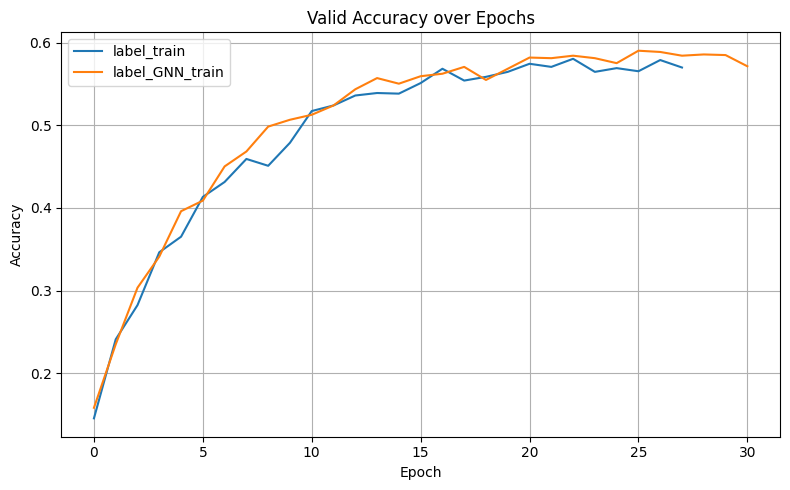

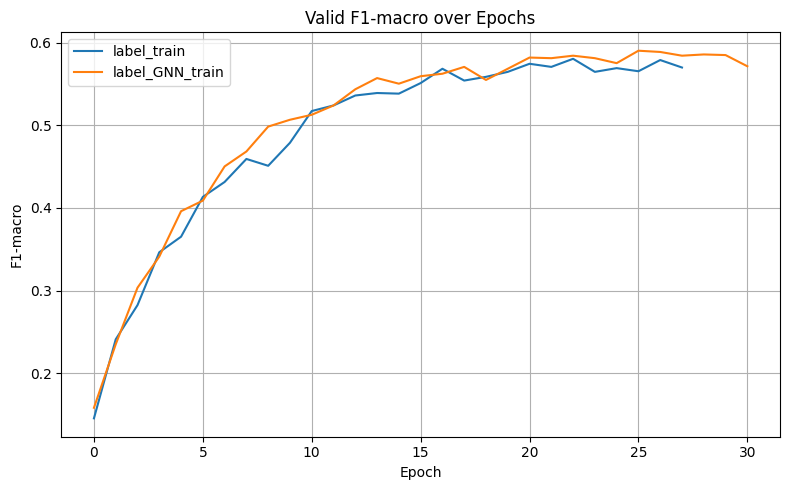

In [27]:
plot_results(results_dict, split="valid")
plot_results(results_dict, split="valid", metric='F1-macro')